In [9]:
%matplotlib inline
import sys
sys.path.append('../instrument_classification')

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from tools import *
from headers import raw_feat_keys
import numpy as np
import argparse
import pickle

from estimator_sel import EstimatorSelection
from gs_params import models, dim_red, dparams, mparams

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, NMF
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import time

import seaborn

def scale_norm(data): 
    return MinMaxScaler().fit_transform(StandardScaler().fit_transform(data))

def read_filt_data(path):
    dataset = []
    targets = []
    for data, instr_cl in parse_data(path):
        for smpl_feats in filter_by_pkey(data, 'sample_'):
            targets.append(instr_cl)
            dataset.append(
                np.hstack(filter_by_key_list(smpl_feats, raw_feat_keys).values())
            )
    return dataset, targets

def data_visualization(X, target, classes):
    fig = plt.figure(figsize=(8, 6))
    plt.clf()
    ax = Axes3D(fig, 
                rect=[0, 0, .95, 1], 
                elev=48, azim=134
               )
    plt.cla()
    for label in classes:

        # Reorder the labels to have colors matching the cluster results
        ax.scatter(
            X[target==label, 0], 
            X[target==label, 1], 
            X[target==label, 2], 
            cmap=plt.cm.spectral,
            edgecolor='k', 
            label=label
        )
        ax.text3D(
            X[target==label, 0].mean(),
            X[target==label, 1].mean(),
            X[target==label, 2].mean(), 
            label,
            horizontalalignment='center',
            bbox=dict(alpha=.5, edgecolor='w', facecolor='w')
        )
    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.legend()
    plt.show()

## Read data, scale and normalize

In [11]:
path='../music_group_ml_test_data/'
X, target = read_filt_data(path)
classes = np.unique(target)
# Scale and normalize data [0,1]
Xn = scale_norm(X)

n_cl = len(np.unique(target))
cl_label_dict = dict(zip(np.unique(target), range(0, n_cl)))
label_cl_dict = {v: k for k, v in cl_label_dict.iteritems()}

y  = np.array([cl_label_dict[e] for e in target])

cl_perc = {i: round(float(target.count(i))/len(y)*100, 2) for i in cl_label_dict.keys()}

print 'DATASET PERCENTAGES:'
for k, v in cl_perc.iteritems():
    print '{0}: {1} %'.format(k, v)

DATASET PERCENTAGES:
hihat: 6.18 %
bass: 19.02 %
guitar: 38.6 %
vocals: 11.24 %
tom: 4.52 %
saxophone: 2.59 %
piano: 8.78 %
snare: 4.52 %
kick: 4.54 %


## Data visualization: principal component and linear discriminant analysis

In [12]:


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
lda = LDA(n_components=3)
pca = PCA(n_components=3)

Xlda = lda.fit_transform(Xn, y)
Xpca = pca.fit_transform(Xn)

print('PCA explained variance ratio (three components): %s'
      % str(pca.explained_variance_ratio_))
print('LDA explained variance ratio (three components): %s'
      % str(lda.explained_variance_ratio_))

PCA explained variance ratio (three components): [ 0.30482647  0.17249742  0.11932403]
LDA explained variance ratio (three components): [ 0.4442665   0.23605284  0.1472224 ]


c:\python27\lib\site-packages\sklearn\discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


<IPython.core.display.Javascript object>


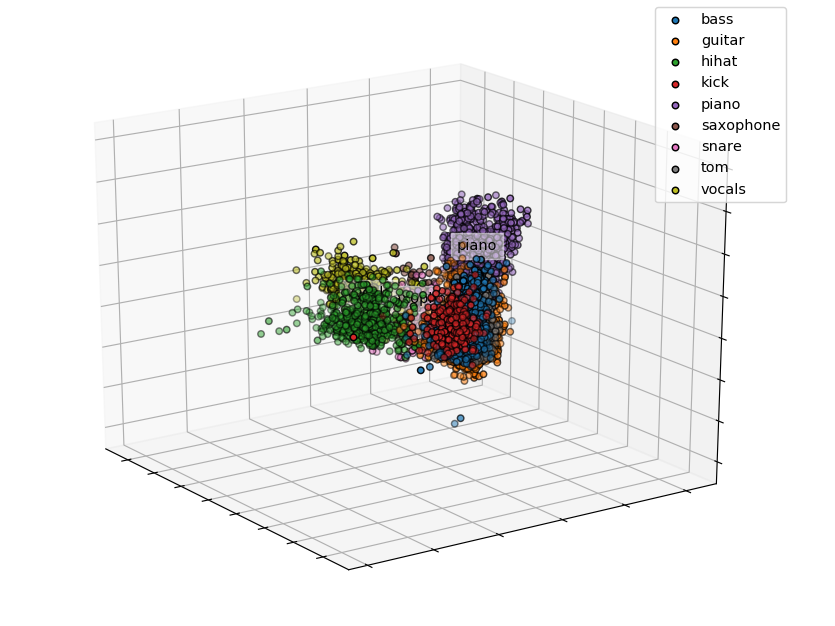

In [13]:
%matplotlib notebook
import matplotlib.pyplot as plt
data_visualization(Xlda, np.array(target), classes)

<IPython.core.display.Javascript object>


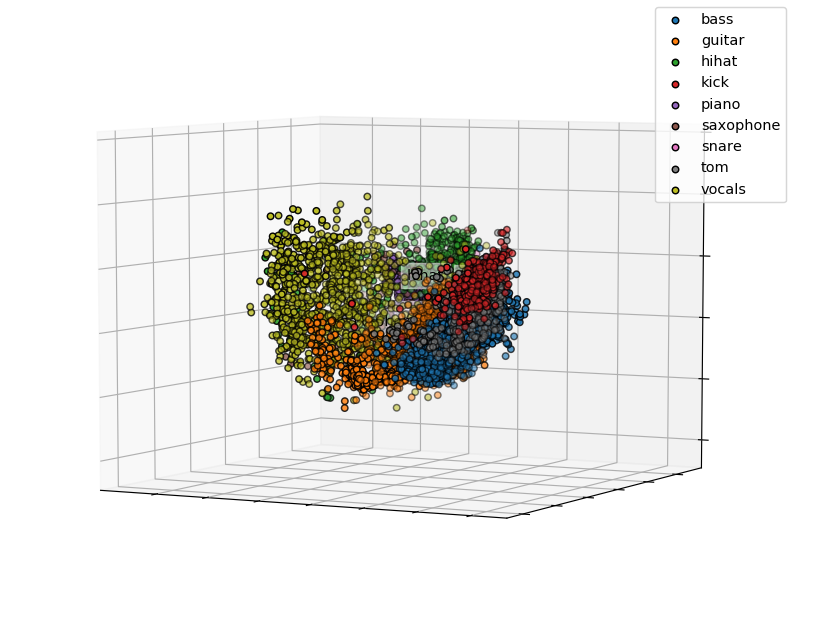

In [14]:
data_visualization(Xpca, np.array(target), classes)

Automatically created module for IPython interactive environment


<IPython.core.display.Javascript object>


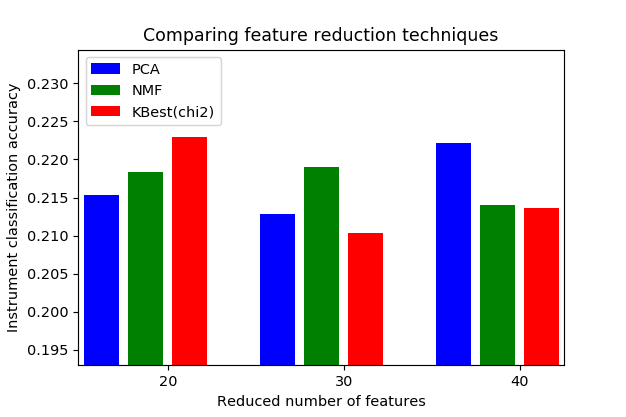

In [20]:

from __future__ import print_function, division
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier as dc
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2

print(__doc__)


pipe = Pipeline([
    ('reduce_dim', None),
    ('classify', dc())
])

N_FEATURES_OPTIONS = [20, 30, 40]
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,

    },
    {
        'reduce_dim': [SelectKBest(chi2)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
    },
]
reducer_labels = ['PCA', 'NMF', 'KBest(chi2)']

grid = GridSearchCV(pipe, cv=3, n_jobs=1, param_grid=param_grid)
grid.fit(Xn, y)

mean_scores = np.array(grid.cv_results_['mean_test_score'])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(1, -1, len(N_FEATURES_OPTIONS))

mean_scores = mean_scores.max(axis=0)
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (len(reducer_labels) + 1) + .5)

plt.figure()
COLORS = 'bgrcmyk'
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("Comparing feature reduction techniques")
plt.xlabel('Reduced number of features')
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel('Instrument classification accuracy')
plt.ylim((0, 1))
plt.legend(loc='upper left')